In [66]:
import tkinter as tk
import tkinter.ttk
from tkinter import filedialog
import pandas as pd
import os
import cv2
import numpy as np
import shutil
from unidecode import unidecode
import re
from PIL import Image, ImageTk

### 기준정보로 등록해야 하는 정보
## GUI 크기
Gsize = "630x550"

## 폴더 / 파일 리스트
# 각 행의 라벨 정보 List로 정리
label_f = ['Asian folder', 'English folder', 'Target folder','Result folder', 'Test file', 'Test Result folder']
# 각 행에서 다루는 값이 폴더일때는 0, 파일일때는 1로 구분자
fileyn = [0, 0, 0, 0, 1, 0]
# 폴더 / 파일 리스트 기준정보 불러오기 (기준정보 관리 파일명 : GUIMaster.csv)
# 기준정보 파일이 없을 경우 초기화
try : 
    df_FileFolder= pd.read_csv("Simple_Image_Judge_Master.csv")
except :
    d = {'Item' : ['Please select file / folder path'] * len(label_f)}
    df_FileFolder = pd.DataFrame(data=d)

## 파라미터 텍스트 상자 리스트
label_para = ['Spec', 'Left', 'Right', 'Top', 'Bottom', 'Spec', 'Left', 'Right', 'Top', 'Bottom']
# 폴더 / 파일 리스트 기준정보 불러오기 (기준정보 관리 파일명 : Para.csv)
# 기준정보 파일이 없을 경우 초기화
try : 
    dfP= pd.read_csv("Simple_Image_Judge_Para.csv")
except :
    # d = {'Item' : [0] * len(label_para)}
    d = {'Item' : [[100], [0], [128], [0], [128], [100], [0], [128], [0], [128]]}
    dfP = pd.DataFrame(data=d)

### 주요 함수
## 개발된 함수 추가

# 한글을 영문으로 변환하는 함수
def korean_to_english(text):
    # 로마자 변환 (ASCII 문자로 변환)
    converted_text = unidecode(text)
    return converted_text

# 디렉토리 내의 모든 파일 처리
def process_directory(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for root, dirs, files in os.walk(source_dir):
        for file_name in files:
            # 한글이 포함된 파일 이름을 영문으로 변환
            new_file_name = korean_to_english(file_name)
            # 새로운 파일 경로
            source_file = os.path.join(root, file_name)
            new_root = root.replace(source_dir, destination_dir)
            new_file_path = os.path.join(new_root, new_file_name)
            
            # 새 디렉토리 경로가 존재하지 않으면 생성
            if not os.path.exists(new_root):
                os.makedirs(new_root)
            
            # 파일 이동
            shutil.copy(source_file, new_file_path)

# 한글 파일 to 영어 파일 실행
def ko2en():
    source_dir = df_FileFolder.Item[0]
    destination_dir = df_FileFolder.Item[1]
    process_directory(source_dir, destination_dir)

# Image Simple Judgement
def simple_judge(judgetype):
    update_Para()
    target_folder = df_FileFolder.Item[2]
    result_folder = df_FileFolder.Item[3]
    SJ_spec = int(dfP.Item[0])
    SJ_left = int(dfP.Item[1])
    SJ_right = int(dfP.Item[2])
    SJ_top = int(dfP.Item[3])
    SJ_bottom = int(dfP.Item[4])

    # Judge progress check logic
    progress = 0
    total_files = len(os.listdir(target_folder))

    for i, filename in enumerate(os.listdir(target_folder)):
        file = os.path.join(target_folder, filename)
        savefilename = os.path.join(result_folder, filename)
        # 이미지 로드
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            print("이미지를 불러오지 못했습니다.")
        else:
            cutted_image = image[SJ_top:SJ_bottom, SJ_left:SJ_right]
            
            match judgetype:
                case 0 :
                    # 이미지 흐리게 만들기
                    blurred_img = cv2.blur(cutted_image,(5,5))
                    # 이미지 이진화 (임계값 : spec 의 70% 값 사용, 필요시 조정 가능)
                    boundary_spec = SJ_spec * 0.7
                    _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY)
                    # 검은색 영역 찾기 (명도 값이 0인 부분)
                    black_area = cutted_image[binary_image == 0]
                    # 검은색 영역 내 명도가 spec을 초과하는지 확인
                    if np.any(black_area > int(SJ_spec)):
                        shutil.copy(file, savefilename)
                case 1 : 
                    # 이미지 흐리게 만들기
                    blurred_img = cv2.blur(cutted_image,(5,5))
                    # 이미지 이진화 (임계값 : 255 - spec 보다 30% 높은 값 사용, 필요시 조정 가능)
                    boundary_spec = SJ_spec + ((255 - SJ_spec) * 0.3)
                    _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY)
                    # 흰색 영역 찾기 (명도 값이 255인 부분)
                    white_area = cutted_image[binary_image == 255]
                    # 흰색 영역 내 명도가 spec 미만인지 확인
                    if np.any(white_area < int(SJ_spec)):
                        shutil.copy(file, savefilename)
                case 2 :
                    # 검은색 영역 내 명도가 spec을 초과하는지 확인
                    if np.any(cutted_image > int(SJ_spec)):
                        shutil.copy(file, savefilename)
                case 3 :
                    # 흰색 영역 내 명도가 spec 미만인지 확인
                    if np.any(cutted_image < int(SJ_spec)):
                        shutil.copy(file, savefilename)
        # Display progress
        progress = (i + 1) / total_files * 100
        label_progress.config(text=f"Progress: {progress:.2f}%")
        label_progress.update()
    label_progress.config(text="Complete")    

def simple_judge_test(judgetype):
    update_Para()
    test_file = df_FileFolder.Item[4]
    result_folder = df_FileFolder.Item[5]
    SJ_spec = int(dfP.Item[5])
    SJ_left = int(dfP.Item[6])
    SJ_right = int(dfP.Item[7])
    SJ_top = int(dfP.Item[8])
    SJ_bottom = int(dfP.Item[9])

    # 이미지 로드
    image = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    ng_image = cv2.imread(test_file)
    if image is None:
        print("이미지를 불러오지 못했습니다.")
    else:
        cutted_image = image[SJ_top:SJ_bottom, SJ_left:SJ_right]
        ng_cutted_image = ng_image[SJ_top:SJ_bottom, SJ_left:SJ_right]
        width, height = SJ_right - SJ_left , SJ_bottom - SJ_top
        match judgetype:
            case 0 :
                # 이미지 흐리게 만들기
                blurred_img = cv2.blur(cutted_image,(5,5))
                # 이미지 이진화 (임계값 : spec 의 70% 값 사용, 필요시 조정 가능)
                boundary_spec = SJ_spec * 0.7
                _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY_INV)
                # 검은색 영역 찾기 (명도 값이 0인 부분 : INV 사용 시 255가 검은색)
                black_area = cutted_image[binary_image == 255]
                masked_image = cv2.bitwise_and(cutted_image, cutted_image, mask=binary_image)
                over_spec = np.where(masked_image > int(SJ_spec))
                # 검은색 영역 내 명도가 spec을 초과하는지 확인
                if np.any(black_area > int(SJ_spec)):
                    ng_cutted_image[over_spec] = [0,0,255]
                    judge_result.config(text="White dot in Black area")
                    # print("White dot in Black area")
                else:
                    judge_result.config(text="No White dot in Black area")
                    
            case 1 : 
                # 이미지 흐리게 만들기
                blurred_img = cv2.blur(cutted_image,(5,5))
                # 이미지 이진화 (임계값 : 255 - spec 보다 30% 높은 값 사용, 필요시 조정 가능)
                boundary_spec = SJ_spec + ((255 - SJ_spec) * 0.3)
                _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY)
                # 검은색 영역 찾기 (명도 값이 255인 부분)
                white_area = cutted_image[binary_image == 255]
                cutted_image2 = cv2.bitwise_not(cutted_image)
                masked_image = cv2.bitwise_and(cutted_image2, cutted_image2, mask=binary_image)
                under_spec = np.where(cv2.bitwise_not(masked_image) < int(SJ_spec))
                # 검은색 영역 내 명도가 spec 미만인지 확인
                if np.any(white_area < int(SJ_spec)):
                    ng_cutted_image[under_spec] = [0,0,255]
                    judge_result.config(text="Black dot in White area")
                    # print("Black dot in White area")
                else:
                    judge_result.config(text="No Black dot in White area")
            case 2 :
                binary_image = np.ones((height, width, 3), dtype=np.uint8) * 255# 결과 이미지 저장
                # 검은색 영역 내 명도가 spec을 초과하는지 확인
                if np.any(cutted_image > int(SJ_spec)):
                    ng_cutted_image[cutted_image > int(SJ_spec)] = [0,0,255]
                    judge_result.config(text="White dot in Area")
                    # print("White dot in Area")
                else:
                    judge_result.config(text="No White dot in Area")
            case 3 :
                binary_image = np.ones((height, width, 3), dtype=np.uint8) * 255# 결과 이미지 저장
                # 흰색 영역 내 명도가 spec 미만인지 확인
                if np.any(cutted_image < int(SJ_spec)):
                    ng_cutted_image[cutted_image < int(SJ_spec)] = [0,0,255]
                    judge_result.config(text="Black dot in Area")
                    # print("Black dot in Area")
                else:
                    judge_result.config(text="No Black dot in Area")
        cv2.imwrite(os.path.join(result_folder, "cutted_image.jpg"), cutted_image)
        cv2.imwrite(os.path.join(result_folder, "binary_image.jpg"), binary_image)
        cv2.imwrite(os.path.join(result_folder, "ng_cutted_image.jpg"), ng_cutted_image)
        image_panel1.image = ImageTk.PhotoImage(Image.open(os.path.join(result_folder, "cutted_image.jpg")))
        image_panel1.config(image=image_panel1.image)
        image_panel2.image = ImageTk.PhotoImage(Image.open(os.path.join(result_folder, "binary_image.jpg")))
        image_panel2.config(image=image_panel2.image)
        image_panel3.image = ImageTk.PhotoImage(Image.open(os.path.join(result_folder, "ng_cutted_image.jpg")))
        image_panel3.config(image=image_panel3.image)

### GUI용 함수
# GUIMaster Data 업데이트 : 
def update_Master(idx, var):
    df_FileFolder.Item[idx] = var
    df_FileFolder.to_csv('Simple_Image_Judge_Master.csv', index=False)

# Para Data 업데이트 :
def update_Para():
    for i in range(len(label_para)):
        dfP.Item[i] = txtPara[i].get("1.0",tk.END)
    dfP.to_csv('Simple_Image_Judge_Para.csv', index=False)

# 폴더/파일 경로 바꾸는 버튼을 눌렀을때 업데이트
def onClick(i, fileYN):
    # 폴더 경로 바꾸는 로직 (fineYN = 0 일때)
    if fileYN == 0:
        folder_selected = filedialog.askdirectory()
        var = folder_selected
    # 파일 경로 바꾸는 로직 (fineYN = 0 이 아닐때)
    else:
        folder_selected = filedialog.askopenfile()
        var = folder_selected.name

    lbPath[i].delete('1.0', tk.END)
    lbPath[i].insert(tk.INSERT, chars=var)
    update_Master(i,var)

# 파라미터 가져오기
def bring_Para(judge):
    if judge == 0:
        for i in range(5):
            txtPara[i].delete('1.0', tk.END)
            txtPara[i].insert(tk.INSERT, chars=dfP.Item[i+5])
            dfP.Item[i] = dfP.Item[i+5]
    else:
        for i in range(5):
            txtPara[i+5].delete('1.0', tk.END)
            txtPara[i+5].insert(tk.INSERT, chars=dfP.Item[i])
            dfP.Item[i+5] = dfP.Item[i]
    dfP.to_csv('Simple_Image_Judge_Para.csv', index=False)
    
## Main Code
# GUI 구성
win = tk.Tk()
win.geometry(Gsize)
win.title('Python Simple image judge')

# Frame notebook(Tab) 설정하기
notebook = tkinter.ttk.Notebook(win)
notebook.pack()

frameSimpleJudge = tk.Frame(win, pady=5, padx = 5)
notebook.add(frameSimpleJudge, text = "Simple Judge")
frameSimpleJudgeTest = tk.Frame(win, pady=5, padx = 5)
notebook.add(frameSimpleJudgeTest, text = "Simple Judge Test")
frameChangePath = tk.Frame(win, pady=5, padx = 5)
notebook.add(frameChangePath, text = "Change Path")

# Frame notebook(Tab)별 내부 구성 (Change Path)
frameCP_F = tk.Frame(frameChangePath, pady=5, padx = 5)
frameCP_F.grid(row=0, column=0, sticky= "ew", padx=5,pady=5)
frameCP_B = tk.Frame(frameChangePath, pady=5, padx = 5)
frameCP_B.grid(row=1, column=0, sticky= "ew", padx=5, pady=5)

# Frame notebook(Tab)별 내부 구성 (Simple Judge)
frameSJ_F = tk.Frame(frameSimpleJudge, pady=5, padx = 5)
frameSJ_F.grid(row=0, column=0, sticky= "ew", padx=5, pady=5)
frameSJ_R = tk.Frame(frameSimpleJudge, pady=5, padx = 5)
frameSJ_R.grid(row=1, column=0, sticky= "ew", padx=5, pady=5)
frameSJ_P = tk.Frame(frameSimpleJudge, pady=5, padx = 5)
frameSJ_P.grid(row=2, column=0, sticky= "ew", padx=5, pady=5)
frameSJ_B = tk.Frame(frameSimpleJudge, pady=5, padx = 5)
frameSJ_B.grid(row=3, column=0, sticky= "ew", padx=5, pady=5)
frameSJ_progress = tk.Frame(frameSimpleJudge, pady=5, padx = 5)
frameSJ_progress.grid(row=4, column=0, sticky= "ew", padx=5, pady=5)

# Frame notebook(Tab)별 내부 구성 (Simple Judge Test)
frameSJT_F = tk.Frame(frameSimpleJudgeTest, pady=5, padx = 5)
frameSJT_F.grid(row=0, column=0, sticky= "ew", padx=5, pady=5)
frameSJT_R = tk.Frame(frameSimpleJudgeTest, pady=5, padx = 5)
frameSJT_R.grid(row=1, column=0, sticky= "ew", padx=5, pady=5)
frameSJT_P = tk.Frame(frameSimpleJudgeTest, pady=5, padx = 5)
frameSJT_P.grid(row=2, column=0, sticky= "ew", padx=5, pady=5)
frameSJT_B = tk.Frame(frameSimpleJudgeTest, pady=5, padx = 5)
frameSJT_B.grid(row=3, column=0, sticky= "ew", padx=5, pady=5)
frameSJT_I = tk.Frame(frameSimpleJudgeTest, pady=5, padx = 5)
frameSJT_I.grid(row=4, column=0, sticky= "ew", padx=5, pady=5)

# 파일 / 폴더 경로 설정 GUI
lbFame = []
lbPath = []
btnPath =[]

for i,x in enumerate(label_f):
    match i:
        case 0 | 1 :
            lbFame.append(tk.Label(frameCP_F, text=x, width=15,padx =5, pady = 5))
            lbPath.append(tk.Text(frameCP_F, width = 50, height = 1, padx =5, pady = 5, background='lightgrey'))
            btnPath.append(tk.Button(frameCP_F, text="Change Path", width=10, padx =5, pady = 5, command=lambda i=i: onClick(i,fileyn[i])))
        case 2 | 3 :
            lbFame.append(tk.Label(frameSJ_F, text=x, width=15, padx =5, pady = 5))
            lbPath.append(tk.Text(frameSJ_F, width = 50, height = 1, padx =5, pady = 5, background='lightgrey'))
            btnPath.append(tk.Button(frameSJ_F, text="Change Path", width=10, padx =5, pady = 5, command=lambda i=i: onClick(i,fileyn[i])))
        case 4 | 5 :
            lbFame.append(tk.Label(frameSJT_F, text=x, width=15, padx =5, pady = 5))
            lbPath.append(tk.Text(frameSJT_F, width = 50, height = 1, padx =5, pady = 5, background='lightgrey'))
            btnPath.append(tk.Button(frameSJT_F, text="Change Path", width=10, padx =5, pady = 5, command=lambda i=i: onClick(i,fileyn[i])))
        
    # 폴더/파일 이름 초기값 넣기
    lbPath[i].insert(tk.INSERT, chars=df_FileFolder.Item[i])

    lbFame[i].grid(row=i, column=0, padx =5, sticky=tk.W)
    lbPath[i].grid(row=i, column=1, padx =5, sticky=tk.W)
    btnPath[i].grid(row=i, column=2, padx =5, sticky=tk.W)

# Parameter 설정 GUI
lbPara = []
txtPara = []

for i,x in enumerate(label_para):
    match i:
        case 0 :
            lbPara.append(tk.Label(frameSJ_P, text=x, width=10))
            txtPara.append(tk.Text(frameSJ_P, width = 25, height = 1, padx =5, pady = 5))
            lbPara[i].grid(row=i, column=0, sticky=tk.W)
            txtPara[i].grid(row=i, column=1, sticky=tk.W)
        case 1 | 2 | 3 | 4 :
            lbPara.append(tk.Label(frameSJ_P, text=x, width=10))
            txtPara.append(tk.Text(frameSJ_P, width = 25, height = 1, padx =5, pady = 5))
            lbPara[i].grid(row=((i-1) // 2) + 1, column = ((i-1) % 2 )* 2 , sticky=tk.W)
            txtPara[i].grid(row=((i-1) // 2) + 1, column=((i-1) % 2 ) * 2 + 1, sticky=tk.W)
        case 5 :
            lbPara.append(tk.Label(frameSJT_P, text=x, width=10))
            txtPara.append(tk.Text(frameSJT_P, width = 25, height = 1, padx =5, pady = 5))
            lbPara[i].grid(row=0, column=0, sticky=tk.W)
            txtPara[i].grid(row=0, column=1, sticky=tk.W)
        case 6 | 7 | 8 | 9 :
            lbPara.append(tk.Label(frameSJT_P, text=x, width=10))
            txtPara.append(tk.Text(frameSJT_P, width = 25, height = 1, padx =5, pady = 5))
            lbPara[i].grid(row=((i) // 2) + 1, column = ((i) % 2 )* 2 , sticky=tk.W)
            txtPara[i].grid(row=((i) // 2) + 1, column=((i) % 2 ) * 2 + 1, sticky=tk.W)
            
    # 파라미터 초기값 넣기
    txtPara[i].insert(tk.INSERT, chars=dfP.Item[i])

# Add parameter change button
button_para_judge = tk.Button(frameSJ_P, text="Bring Para from test", width = 20, padx=5, command=lambda: bring_Para(0))
button_para_test = tk.Button(frameSJT_P, text="Bring Para from judge", width = 20, padx=5, command=lambda: bring_Para(1))
button_para_judge.grid(row=0, column=3, columnspan=2, sticky=tk.E)
button_para_test.grid(row=0, column=3, columnspan=2, sticky=tk.E)


# Simple Judge Radio 상자 GUI
SJ_var = tk.IntVar()
SJ_var.set(0)

SJ_List = ['White dot in Black area','Black dot in White area', 'White dot in Area', 'Black dot in Area']
SJ_radio = []
for i,x in enumerate(SJ_List):
    SJ_radio.append(tk.Radiobutton(frameSJ_R, text=x, variable=SJ_var, width = 35, padx=1, value=i))
    SJ_radio[i].grid(row=i//2, column=i%2, sticky=tk.W)

# Simple Judge Test Radio 상자 GUI
SJT_var = tk.IntVar()
SJT_var.set(0)

SJT_List = ['White dot in Black area','Black dot in White area', 'White dot in Area', 'Black dot in Area']
SJT_radio = []
for i,x in enumerate(SJT_List):
    SJT_radio.append(tk.Radiobutton(frameSJT_R, text=x, variable=SJT_var, width = 35, padx=1, value=i))
    SJT_radio[i].grid(row=i//2, column=i%2, sticky=tk.W)

# Path Change Button GUI
button_path = tk.Button(frameCP_B, text="Apply Change", width = 30, padx=5, command=lambda: ko2en())
# button_path.grid(row=0, column=0, sticky=tk.E)
button_path.pack()

# Simple Judge Button GUI
button_simple = tk.Button(frameSJ_B, text="Run Simple Judge", width = 30, padx=5, command=lambda: simple_judge(SJ_var.get()))
button_simple.pack()

# Simple Judge Test Button GUI
button_simple_test = tk.Button(frameSJT_B, text="Run Simple Judge Test", width = 30, padx=5, command=lambda: simple_judge_test(SJT_var.get()))
button_simple_test.pack()

# Simple Judge Progress GUI
label_progress = tk.Label(frameSJ_progress, width = 30, padx=5)
label_progress.pack()

# Simple Judge Image GUI
image_panel1 = tk.Label(frameSJT_I)
image_panel2 = tk.Label(frameSJT_I)
image_panel3 = tk.Label(frameSJT_I)
Image_description1 = tk.Label(frameSJT_I, text="Cutted Image", padx=5)
Image_description2 = tk.Label(frameSJT_I, text="Check Area(White)", padx=5)
Image_description3 = tk.Label(frameSJT_I, text="NG Area(Red)", padx=5)
judge_result = tk.Label(frameSJT_I, width = 85, padx=5)
image_panel1.grid(row=0, column=0)
image_panel2.grid(row=0, column=1)
image_panel3.grid(row=0, column=2)
Image_description1.grid(row=1, column=0)
Image_description2.grid(row=1, column=1)
Image_description3.grid(row=1, column=2)
judge_result.grid(row=2, column=0, columnspan=3)

win.mainloop()

C:\Users\550sn\AppData\Local\Temp\ipykernel_14540\980734172.py:233: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dfP.Item[i] = txtPara[i].get("1.0",tk.END)
C:\Users\550sn\AppData\Local\Temp\ipykernel_14540\980734172.py:233: FutureWarning: S

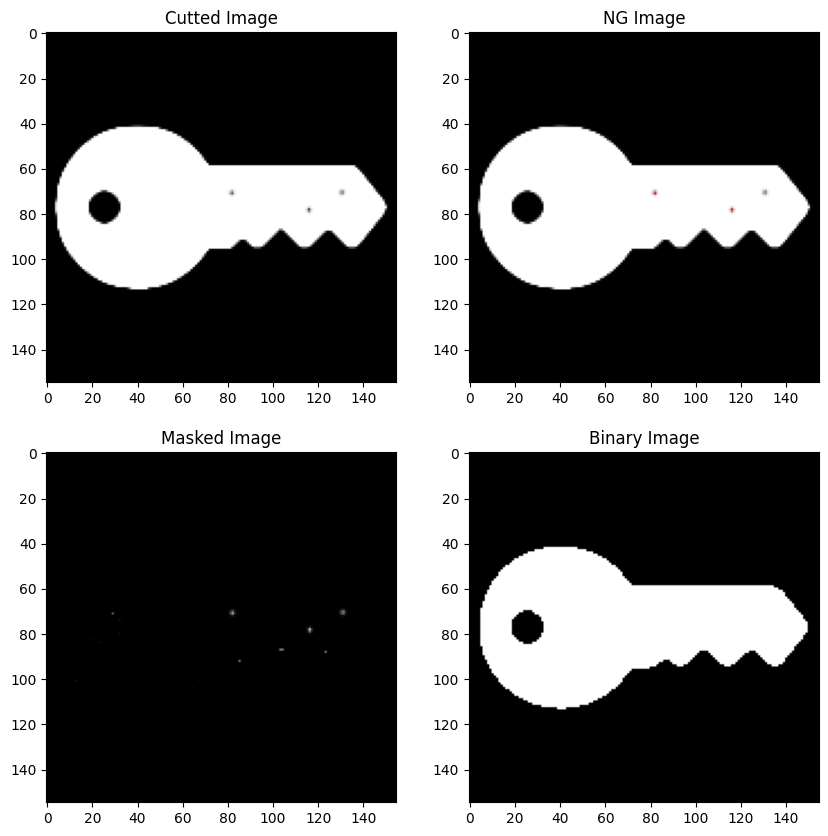

In [41]:
import matplotlib.pyplot as plt
import numpy as np

test_file = r'C:\Data\Sample\IMG_Judge\White Test\NGKey1.png'
SJ_spec = 100
SJ_left = 0
SJ_right = 155
SJ_top = 0
SJ_bottom = 155

# 이미지 로드
image = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
ng_image = cv2.imread(test_file)
if image is None:
    print("이미지를 불러오지 못했습니다.")
else:
    cutted_image = image[SJ_top:SJ_bottom, SJ_left:SJ_right]
    ng_cutted_image = ng_image[SJ_top:SJ_bottom, SJ_left:SJ_right]
    # 이미지 흐리게 만들기
    blurred_img = cv2.blur(cutted_image,(5,5))
    # 이미지 이진화 (임계값 : 255 - spec 보다 30% 높은 값 사용, 필요시 조정 가능)
    boundary_spec = SJ_spec + ((255 - SJ_spec) * 0.3)
    _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY)
    # 검은색 영역 찾기 (명도 값이 255인 부분)
    white_area = cutted_image[binary_image == 255]
    cutted_image2 = cv2.bitwise_not(cutted_image)
    masked_image = cv2.bitwise_and(cutted_image2, cutted_image2, mask=binary_image)
    under_spec = np.where(cv2.bitwise_not(masked_image) < int(SJ_spec))
    # 검은색 영역 내 명도가 spec 미만인지 확인
    if np.any(white_area < int(SJ_spec)):
        ng_cutted_image[under_spec] = [0,0,255]
    
    # # 이미지 흐리게 만들기
    # blurred_img = cv2.blur(cutted_image,(5,5))
    # # 이미지 이진화 (임계값 : spec 의 70% 값 사용, 필요시 조정 가능)
    # boundary_spec = SJ_spec * 0.7
    # _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY_INV)
    # # 검은색 영역 찾기 (명도 값이 0인 부분 : INV 사용 시 255가 검은색)
    # black_area = cutted_image[binary_image == 255]
    # masked_image = cv2.bitwise_and(cutted_image, cutted_image, mask=binary_image)
    # over_spec = np.where(masked_image > int(SJ_spec))
    # # 검은색 영역 내 명도가 spec을 초과하는지 확인
    # if np.any(black_area > int(SJ_spec)):
    #     ng_cutted_image[over_spec] = [0,0,255]
        
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(cv2.cvtColor(cutted_image, cv2.COLOR_BGR2RGB)), plt.title('Cutted Image')
plt.subplot(222), plt.imshow(cv2.cvtColor(ng_cutted_image, cv2.COLOR_BGR2RGB)), plt.title('NG Image')
plt.subplot(223), plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)), plt.title('Masked Image')
plt.subplot(224), plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)), plt.title('Binary Image')
plt.show()


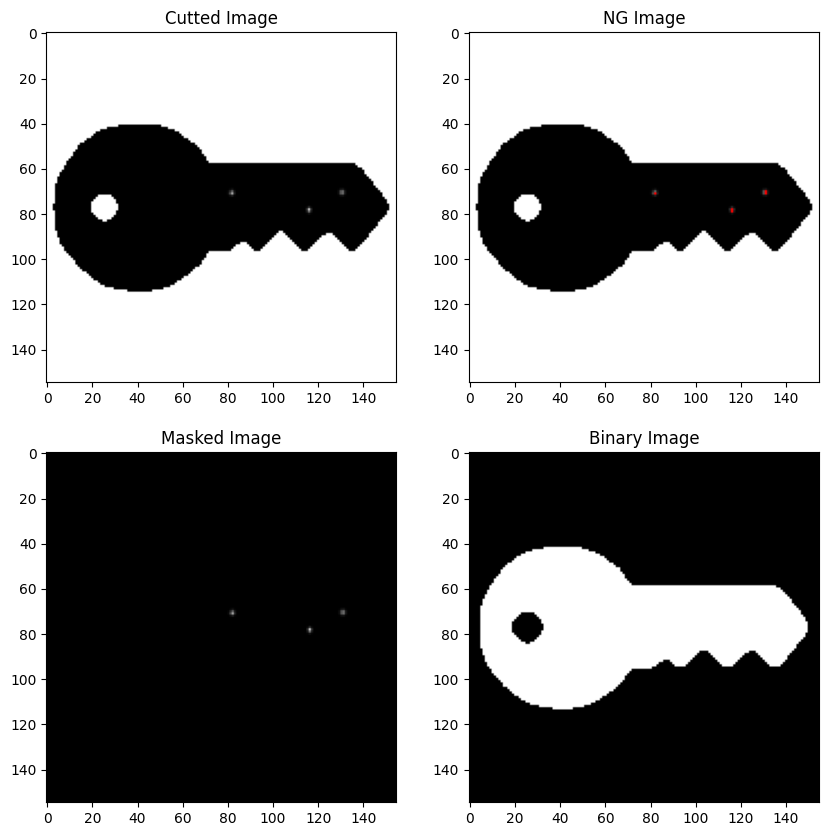

In [33]:
import matplotlib.pyplot as plt
import numpy as np

test_file = r'C:\Data\Sample\IMG_Judge\Test\NGKey1.png'
SJ_spec = 100
SJ_left = 0
SJ_right = 155
SJ_top = 0
SJ_bottom = 155

# 이미지 로드
image = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
ng_image = cv2.imread(test_file)
if image is None:
    print("이미지를 불러오지 못했습니다.")
else:
    cutted_image = image[SJ_top:SJ_bottom, SJ_left:SJ_right]
    ng_cutted_image = ng_image[SJ_top:SJ_bottom, SJ_left:SJ_right]
    
    # # 이미지 흐리게 만들기
    # blurred_img = cv2.blur(cutted_image,(5,5))
    # # 이미지 이진화 (임계값 : 255 - spec 보다 30% 높은 값 사용, 필요시 조정 가능)
    # boundary_spec = SJ_spec + ((255 - SJ_spec) * 0.3)
    # _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY)
    # # 검은색 영역 찾기 (명도 값이 255인 부분)
    # white_area = cutted_image[binary_image == 255]
    # masked_image = cv2.bitwise_and(cutted_image, cutted_image, mask=binary_image)
    # under_spec = np.where(masked_image < int(SJ_spec))
    # # 검은색 영역 내 명도가 spec 미만인지 확인
    # if np.any(white_area < int(SJ_spec)):
    #     ng_cutted_image[under_spec] = [0,0,255]
    
    # 이미지 흐리게 만들기
    blurred_img = cv2.blur(cutted_image,(5,5))
    # 이미지 이진화 (임계값 : spec 의 70% 값 사용, 필요시 조정 가능)
    boundary_spec = SJ_spec * 0.7
    _, binary_image = cv2.threshold(blurred_img, boundary_spec, 255, cv2.THRESH_BINARY_INV)
    # 검은색 영역 찾기 (명도 값이 0인 부분 : INV 사용 시 255가 검은색)
    black_area = cutted_image[binary_image == 255]
    masked_image = cv2.bitwise_and(cutted_image, cutted_image, mask=binary_image)
    over_spec = np.where(masked_image > int(SJ_spec))
    # 검은색 영역 내 명도가 spec을 초과하는지 확인
    if np.any(black_area > int(SJ_spec)):
        ng_cutted_image[over_spec] = [0,0,255]
        
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(cv2.cvtColor(cutted_image, cv2.COLOR_BGR2RGB)), plt.title('Cutted Image')
plt.subplot(222), plt.imshow(cv2.cvtColor(ng_cutted_image, cv2.COLOR_BGR2RGB)), plt.title('NG Image')
plt.subplot(223), plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)), plt.title('Masked Image')
plt.subplot(224), plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)), plt.title('Binary Image')
plt.show()
